# Imports

In [26]:
import pandas as pd
import numpy as np 

from pyhhmm.gaussian import GaussianHMM

import yfinance as yf

import matplotlib.pyplot as plt

from datetime import datetime

# Fetch Data

In [27]:
# Data Extraction
start_date = "2020-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
symbol = "SPY"

# USE YAHOO FINANCE 
data = yf.download(symbol ,  start_date , end_date )
data = data[["Open" , "High" , "Low" , "Close" , "Volume"]]

[*********************100%***********************]  1 of 1 completed


In [28]:
# Add Returns and Range    
# Returns = (todays price divided by yesterdays)     # ROI since Yesterday
# Range   = (todays high price divided todays low)   # volitility from highest point to lowest within day

df = data.copy()
df["Returns"] = (df["Close"] / df["Close"].shift(1)) - 1
df["Range"]   = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)

print("Length: ", len(df))

Length:  991


# Add Moving Average

In [29]:
df["12_MA"] = df["Close"].rolling(window=12).mean()
df["21_MA"] = df["Close"].rolling(window=21).mean()

# Train/Test Split Data

In [30]:
# Drop NA
df = df.dropna()

# Split Data into Two sets
train_amount = len(df)//2
test_amount = len(df) - train_amount

x_train = df[["Returns" , "Range"]].iloc[:train_amount]
x_test = df[["Returns" , "Range"]].iloc[test_amount:]
save_df = df.iloc[test_amount:]



print(f"Train Data Length: {len(x_train)}")
print(f"Test Data Length: {len(x_test)}")

Train Data Length: 485
Test Data Length: 485


# Train HMM

In [31]:
# Train Hidden Markov Model
model = GaussianHMM(n_states=4, covariance_type="full" , n_emissions=2)
train = model.train([np.array(x_train.values)])

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


# Test HMM

In [32]:
# Test Hidden Markov Model
test = model.predict([x_train.values])[0]

# Test Predictions

In [33]:
df_main = save_df.copy()
df_main.drop(columns = ["High" , "Low"], inplace = True)

hmm_results = model.predict([x_train.values])[0]
df_main["HMM"] = hmm_results

# Run BackTest
- if the 12 day moving average is greater than the 21 day moving average, place signal
    -  1 : go long
    -  0 : do nothing
    - -1 : go short

In [34]:
# Signals
df_main.loc[df_main["12_MA"] > df_main["21_MA"] , "MA_Signal" ] = 1
df_main.loc[df_main["12_MA"] <= df_main["21_MA"] , "MA_Signal" ] = 0

# Decide Favorable States

In [35]:
# Check Each row to see if within positive signals from HMM    

# HARDCODED FAVORABLE STATES 
favorable_states = [0,3]


hmm_values = df_main["HMM"].values

# 0 if no   ||   1 if yes
hmm_values = [1 if x in favorable_states else 0 for x in hmm_values]


df_main["HMM_Signal"] = hmm_values

In [36]:
# Add Combined "Main" Signal   (if moving average and HMM signals are green)
df_main["Main_Signal"] = 0
df_main.loc[   (df_main["MA_Signal"] == 1) &  (df_main["HMM_Signal"] == 1 ), "Main_Signal" ] = 1

df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [37]:
# Benchmmark Returns
df_main["lrets_bench"] = np.log(df_main["Close"] / df_main["Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exponent"] = np.exp(df_main["bench_prod"]) - 1

In [38]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exponent"] = np.exp(df_main["lrets_prod"]) - 1


# Review Results


In [39]:
df_main.dropna(inplace=True)


df_main.tail(10)

,Open,Close,Volume,Returns,Range,12_MA,21_MA,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exponent,lrets_strat,lrets_prod,strat_prod_exponent
Date,,,,,,,,,,,,,,,,,
2023-11-24,455.070007,455.299988,29737400,0.000615,0.001693,447.430832,437.472380,1,1.0,0,0.0,0.000615,-0.028323,-0.027926,-0.000000,-0.017054,-0.016910
2023-11-27,454.649994,454.480011,50506000,-0.001801,0.003105,448.866666,439.469048,1,1.0,0,0.0,-0.001803,-0.030126,-0.029677,-0.000000,-0.017054,-0.016910
2023-11-28,454.079987,454.929993,62115000,0.000990,0.006108,450.624166,441.576191,0,1.0,1,0.0,0.000990,-0.029136,-0.028716,0.000000,-0.017054,-0.016910
2023-11-29,457.149994,454.609985,63146000,-0.000703,0.009071,451.790833,443.434285,0,1.0,1,1.0,-0.000704,-0.029840,-0.029399,-0.003660,-0.020714,-0.020501
2023-11-30,455.480011,456.399994,79752700,0.003937,0.007544,453.141665,445.253332,0,1.0,1,1.0,0.003930,-0.025910,-0.025578,0.000636,-0.020078,-0.019878
2023-12-01,455.769989,459.100006,89097900,0.005916,0.009865,454.005831,446.988570,0,1.0,1,1.0,0.005898,-0.020012,-0.019813,-0.000373,-0.020451,-0.020243
2023-12-04,455.600006,456.690002,72430900,-0.005249,0.010521,454.589999,448.223332,0,1.0,1,1.0,-0.005263,-0.025275,-0.024958,-0.000747,-0.021197,-0.020974
2023-12-05,455.260010,456.600006,69793500,-0.000197,0.005980,455.120832,449.266666,0,1.0,1,1.0,-0.000197,-0.025472,-0.025151,0.007767,-0.013430,-0.013340
2023-12-06,458.809998,454.760010,69124700,-0.004030,0.009971,455.451665,450.174761,0,1.0,1,1.0,-0.004038,-0.029510,-0.029079,-0.004150,-0.017580,-0.017426


# Calculate Metrics

In [40]:
# Sharpe Ratio Function
def sharpe_ratio_calc(returns_series):
    TradingDays = 255
    TradingDays_SQRT = np.sqrt(TradingDays)
    risk_free_rate = 0.01
    mean = returns_series.mean() * TradingDays
    sigma = returns_series.std() * TradingDays_SQRT
    sharpe_ratio = round((mean - risk_free_rate) / sigma , 2 )
    return sharpe_ratio

In [41]:
# Metrics
bench_returns = round(df_main["bench_prod_exponent"].values[-1] * 100 , 1)
strategy_returns = round(df_main["strat_prod_exponent"].values[-1] * 100 , 1)


bench_sharpe = sharpe_ratio_calc(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio_calc(df_main["lrets_strat"].values)

In [42]:
# Print metrics
print(f"Returns Benchmark: {bench_returns}%")
print(f"Returns Strategy: {strategy_returns}%")

print("-------------------")

print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")



print("\n\n Sharpe ratio is saying 'for every dollar of risk, how many dollars am i getting back?'")

Returns Benchmark: -2.2%
Returns Strategy: -1.6%
-------------------
Sharpe Benchmark: -0.11
Sharpe Strategy: -0.18


 Sharpe ratio is saying 'for every dollar of risk, how many dollars am i getting back?'


# Plot Results

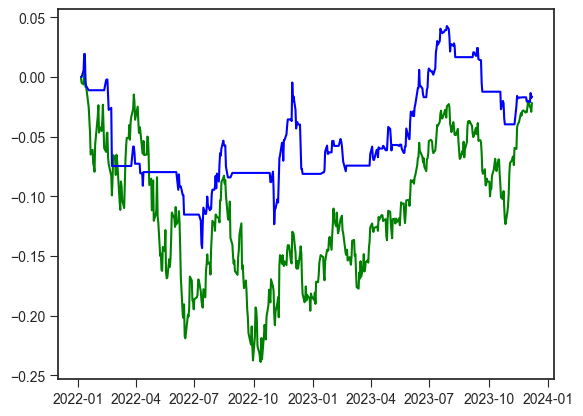

In [43]:
# Plot Equity Curves
fig = plt.Figure(figsize=(18,10))
plt.plot(df_main["bench_prod_exponent"], color="green" )
plt.plot(df_main["strat_prod_exponent"] , color="blue")

plt.show()

Check pass length of Close matches Hidden states array:  False


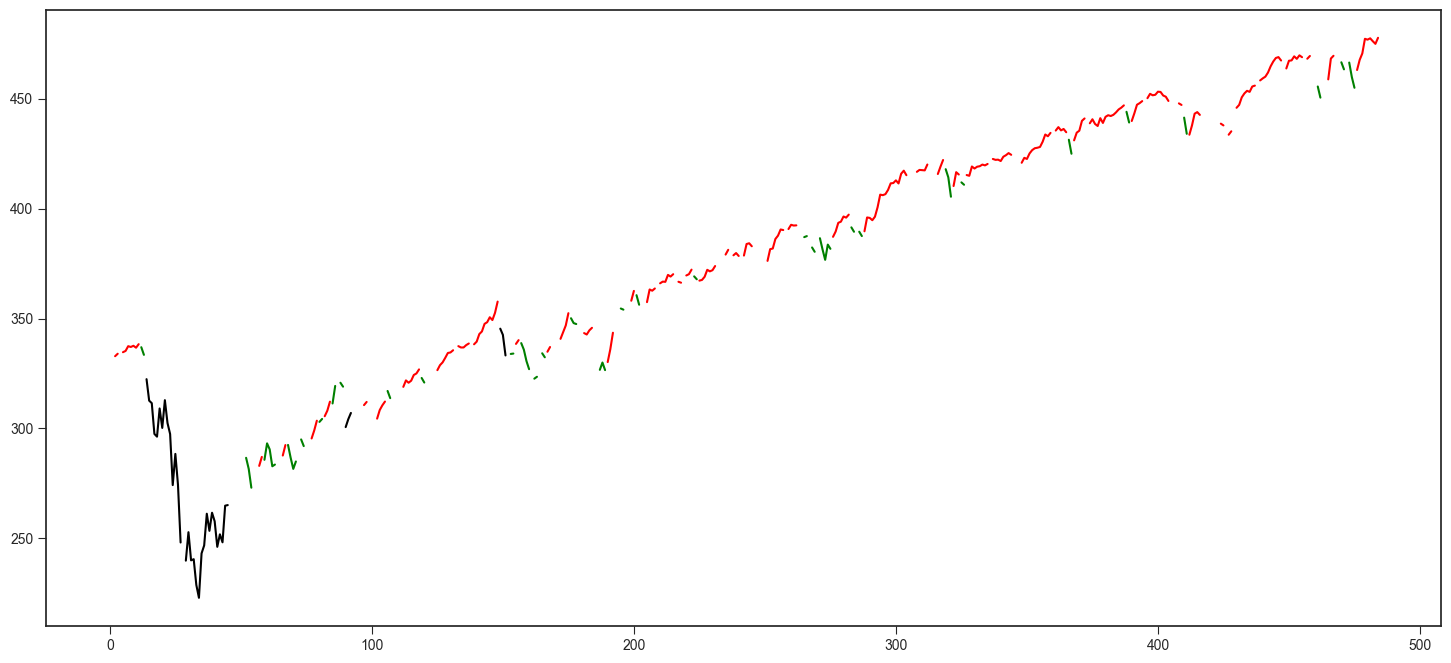

In [44]:
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []


prices = df["Close"].values.astype(float)


print("Check pass length of Close matches Hidden states array: " , len(prices)  ==  len(hmm_results)  )


for s in range(0,len(hmm_results), 1):
    if hmm_results[s] == 0:
        labels_0.append(prices[s])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif hmm_results[s]  == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[s])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    elif hmm_results[s]  == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[s])
        labels_3.append(float('nan'))
    elif hmm_results[s]  == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[s])


# Plot Chart
figure = plt.figure(figsize=(18,8))

plt.plot(labels_0,color="red")
plt.plot(labels_1,color="green")
plt.plot(labels_2,color="orange")
plt.plot(labels_3,color="black")
plt.show()

# SAVE DATA

In [45]:
df_main.to_csv(f"data-storage/HMM-{symbol}.csv")
df_main.to_csv(f"../3_Deep-Learning/data-storage/HMM-{symbol}.csv")